In [1]:
import itertools
import json
import os
from random import sample

import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

from database import data_utils

import importlib
importlib.reload(data_utils)

<module 'database.data_utils' from '/Users/zack/Desktop/valle/src/database/data_utils.py'>

In [2]:
# Read in DeepTTE results
kcm_deeptte_preds = pd.read_csv("../results/kcm2weeks/deeptte.res", delimiter=" ", header=None)
kcm_deeptte_preds.columns = ["label", "pred"]

nwy_deeptte_preds = pd.read_csv("../results/nwy2weeks/deeptte.res", delimiter=" ", header=None)
nwy_deeptte_preds.columns = ["label", "pred"]

In [3]:
# Read in config file
with open("../results/kcm2weeks/data/config.json") as f:
    kcm_config = json.load(f)

with open("../results/nwy2weeks/data/config.json") as f:
    nwy_config = json.load(f)

In [4]:
# Read in test data
kcm_contents = open("../results/kcm2weeks/data/test", "r").read()
kcm_test_data = [json.loads(str(item)) for item in kcm_contents.strip().split('\n')]

nwy_contents = open("../results/nwy2weeks/data/test", "r").read()
nwy_test_data = [json.loads(str(item)) for item in nwy_contents.strip().split('\n')]

In [5]:
# Read in train data
kcm_train_data = []
for i in range(0,5):
    kcm_contents = open("../results/kcm2weeks/data/train_0"+str(i), "r").read()
    kcm_train_data.append([json.loads(str(item)) for item in kcm_contents.strip().split('\n')])
kcm_train_data = list(itertools.chain.from_iterable(kcm_train_data))

nwy_train_data = []
for i in range(0,5):
    nwy_contents = open("../results/nwy2weeks/data/train_0"+str(i), "r").read()
    nwy_train_data.append([json.loads(str(item)) for item in nwy_contents.strip().split('\n')])
nwy_train_data = list(itertools.chain.from_iterable(nwy_train_data))

In [6]:
# Calculate average speed grouped by time of day
dists = [x['dist'] for x in nwy_train_data]
times = [x['time'] for x in nwy_train_data]
hours = [x['timeID'] // 60 for x in nwy_train_data]
speeds = [dists[i] / times[i] for i in range(0,len(dists))] # km/s
nwy_avg_speeds = pd.DataFrame({"hour":hours, "speed":speeds}).groupby("hour").mean().to_dict()
# Predict travel time based on historical average speeds
hours = [x['timeID'] // 60 for x in nwy_test_data]
dists = [x['dist'] for x in nwy_test_data]
speeds = [nwy_avg_speeds['speed'][x] for x in hours]
nwy_avg_preds = [dists[i] / speeds[i] for i in range(0,len(dists))]

# Calculate average speed grouped by time of day
dists = [x['dist'] for x in kcm_train_data]
times = [x['time'] for x in kcm_train_data]
hours = [x['timeID'] // 60 for x in kcm_train_data]
speeds = [dists[i] / times[i] for i in range(0,len(dists))] # km/s
kcm_avg_speeds = pd.DataFrame({"hour":hours, "speed":speeds}).groupby("hour").mean().to_dict()
# Predict travel time based on historical average speeds
hours = [x['timeID'] // 60 for x in kcm_test_data]
dists = [x['dist'] for x in kcm_test_data]
speeds = [kcm_avg_speeds['speed'][x] for x in hours]
kcm_avg_preds = [dists[i] / speeds[i] for i in range(0,len(dists))]

In [7]:
# Resample GPS points to fixed number
nwy_train_data_resample = data_utils.resample_deeptte_gps(nwy_train_data, 128)
nwy_test_data_resample = data_utils.resample_deeptte_gps(nwy_test_data, 128)

kcm_train_data_resample = data_utils.resample_deeptte_gps(kcm_train_data, 128)
kcm_test_data_resample = data_utils.resample_deeptte_gps(kcm_test_data, 128)

In [8]:
# Reshape the resampled GPS data to a 2d np array for train/testing additional models
X_train_nwy, y_train_nwy = data_utils.format_deeptte_to_features(nwy_train_data, nwy_train_data_resample)
X_test_nwy, y_test_nwy = data_utils.format_deeptte_to_features(nwy_test_data, nwy_test_data_resample)

X_train_kcm, y_train_kcm = data_utils.format_deeptte_to_features(kcm_train_data, kcm_train_data_resample)
X_test_kcm, y_test_kcm = data_utils.format_deeptte_to_features(kcm_test_data, kcm_test_data_resample)

In [9]:
# Train GBDT on training data, make preds on test data
nwy_reg = GradientBoostingRegressor(random_state=0)
nwy_reg.fit(X_train_nwy, y_train_nwy)
GradientBoostingRegressor(random_state=0)
nwy_gbdt_preds = nwy_reg.predict(X_test_nwy)

kcm_reg = GradientBoostingRegressor(random_state=0)
kcm_reg.fit(X_train_kcm, y_train_kcm)
GradientBoostingRegressor(random_state=0)
kcm_gbdt_preds = kcm_reg.predict(X_test_kcm)

In [10]:
# Compare different methods for predicting travel times of the test data
model_performances = {
    "MAPE": {
        "Trondheim": {
            "DeepTTE": metrics.mean_absolute_percentage_error(nwy_deeptte_preds.label, nwy_deeptte_preds.pred),
            "GBDT": metrics.mean_absolute_percentage_error(nwy_gbdt_preds, [x['time'] for x in nwy_test_data]),
            "AVG": metrics.mean_absolute_percentage_error(nwy_avg_preds, [x['time'] for x in nwy_test_data])
        },
        "Seattle": {
            "DeepTTE": metrics.mean_absolute_percentage_error(kcm_deeptte_preds.label, kcm_deeptte_preds.pred),
            "GBDT": metrics.mean_absolute_percentage_error(kcm_gbdt_preds, [x['time'] for x in kcm_test_data]),
            "AVG": metrics.mean_absolute_percentage_error(kcm_avg_preds, [x['time'] for x in kcm_test_data])
        }
    },
    "RMSE": {
        "Trondheim": {
            "DeepTTE": np.sqrt(metrics.mean_squared_error(nwy_deeptte_preds.label, nwy_deeptte_preds.pred)),
            "GBDT": np.sqrt(metrics.mean_squared_error(nwy_gbdt_preds, [x['time'] for x in nwy_test_data])),
            "AVG": np.sqrt(metrics.mean_squared_error(nwy_avg_preds, [x['time'] for x in nwy_test_data]))
        },
        "Seattle": {
            "DeepTTE": np.sqrt(metrics.mean_squared_error(kcm_deeptte_preds.label, kcm_deeptte_preds.pred)),
            "GBDT": np.sqrt(metrics.mean_squared_error(kcm_gbdt_preds, [x['time'] for x in kcm_test_data])),
            "AVG": np.sqrt(metrics.mean_squared_error(kcm_avg_preds, [x['time'] for x in kcm_test_data]))
        }
    },
    "MAE": {
        "Trondheim": {
            "DeepTTE": metrics.mean_absolute_error(nwy_deeptte_preds.label, nwy_deeptte_preds.pred),
            "GBDT": metrics.mean_absolute_error(nwy_gbdt_preds, [x['time'] for x in nwy_test_data]),
            "AVG": metrics.mean_absolute_error(nwy_avg_preds, [x['time'] for x in nwy_test_data])
        },
        "Seattle": {
            "DeepTTE": metrics.mean_absolute_error(kcm_deeptte_preds.label, kcm_deeptte_preds.pred),
            "GBDT": metrics.mean_absolute_error(kcm_gbdt_preds, [x['time'] for x in kcm_test_data]),
            "AVG": metrics.mean_absolute_error(kcm_avg_preds, [x['time'] for x in kcm_test_data])
        }
    }
}
model_performances_df = []
for metric in model_performances.keys():
    df = pd.DataFrame(model_performances[metric]).reset_index()
    df = df.melt(id_vars="index", value_vars=['Trondheim', 'Seattle'])
    df['Metric'] = metric
    model_performances_df.append(df)
model_performances_df = pd.concat(model_performances_df)
model_performances_df.columns = ["Model","City","value","Metric"]
model_performances_df

,Model,City,value,Metric
0,DeepTTE,Trondheim,0.086576,MAPE
1,GBDT,Trondheim,0.127635,MAPE
2,AVG,Trondheim,0.325473,MAPE
3,DeepTTE,Seattle,0.142112,MAPE
4,GBDT,Seattle,0.153147,MAPE
5,AVG,Seattle,0.650413,MAPE
0,DeepTTE,Trondheim,329.799330,RMSE
1,GBDT,Trondheim,292.090103,RMSE
2,AVG,Trondheim,979.122032,RMSE
3,DeepTTE,Seattle,693.519187,RMSE


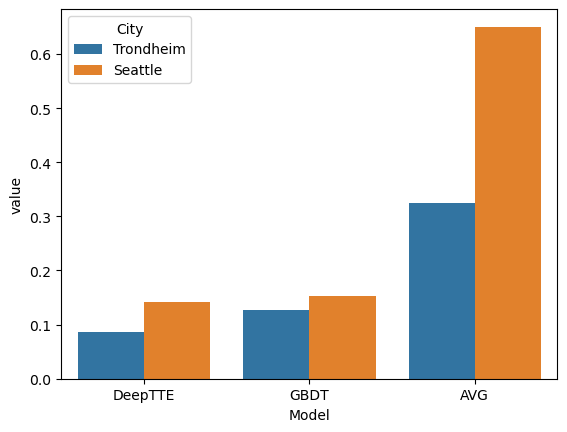

In [11]:
# Plot accuracy across all models
fig, ax = plt.subplots(1,1)
sns.barplot(model_performances_df[model_performances_df['Metric']=='MAPE'], x="Model", y="value", hue="City")
plt.savefig("../plots/model_performances.png", dpi=1800, bbox_inches='tight')

In [16]:
# List of feature names for understanding importance
feature_names = ['timeID','weekID','dateID','driverID','dist']
feature_names = feature_names + [f"lat_{x}" for x in range(128)]
feature_names = feature_names + [f"lng_{x}" for x in range(128)]

In [17]:
# Sort importances and names
nwy_features_sorted = [x for _, x in sorted(zip(nwy_reg.feature_importances_, feature_names))][::-1]
nwy_importances_sorted = [_ for _, x in sorted(zip(nwy_reg.feature_importances_, feature_names))][::-1]
kcm_features_sorted = [x for _, x in sorted(zip(kcm_reg.feature_importances_, feature_names))][::-1]
kcm_importances_sorted = [_ for _, x in sorted(zip(kcm_reg.feature_importances_, feature_names))][::-1]

# Read out names and importances of top n
print(nwy_features_sorted[:10])
print(kcm_features_sorted[:10])

['dist', 'timeID', 'lng_73', 'lng_69', 'lng_0', 'lng_96', 'lng_72', 'lng_109', 'lng_66', 'lng_75']
['dist', 'timeID', 'driverID', 'lat_20', 'lng_71', 'weekID', 'lat_0', 'lat_10', 'lng_107', 'lat_39']


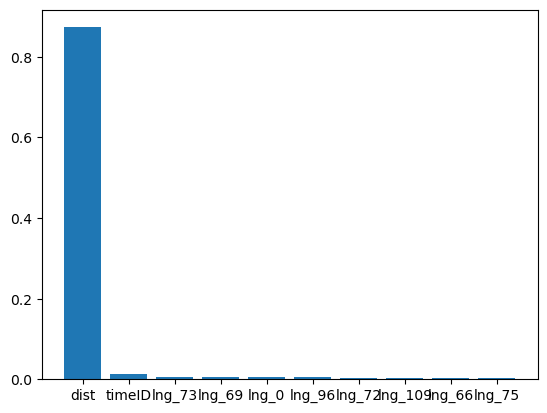

In [19]:
# Plot importances
fig, ax = plt.subplots(1,1)
plt.bar(nwy_features_sorted[:10], nwy_importances_sorted[:10])
plt.savefig("../plots/nwy_gbdt_importances.png", dpi=1800, bbox_inches='tight')

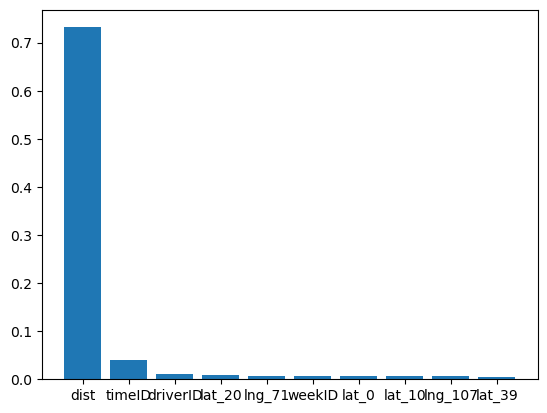

In [20]:
# Plot importances
fig, ax = plt.subplots(1,1)
plt.bar(kcm_features_sorted[:10], kcm_importances_sorted[:10])
plt.savefig("../plots/kcm_gbdt_importances.png", dpi=1800, bbox_inches='tight')